# Salt segmentation using Keras

## Introduction

This is to segment salt deposits beneath the Earth's surface.
Data is from TGS Salt Identification Challenge (https://www.kaggle.com/c/tgs-salt-identification-challenge/data).
80 training images and 80 masks(a portion of the data from TGS) are used in this experiment. The architecture used in this work is called U-net, which is common for segmentation problems, please check here (https://arxiv.org/pdf/1505.04597.pdf) for the original paper on U-net.

## Environment set-up

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from os import listdir

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

## Functions

In [4]:
def get_data(path, im_height, im_width, im_chan):
    '''load the images and resize each image to (im_height,im_width, im_chan)'''
    ids = next(os.walk(path + '/images/'))[2]
    X = np.zeros((len(ids), im_height, im_width, im_chan), dtype=np.float32)
    y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images...')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = img_to_array(load_img(path + '/images/' + id_))
        img = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/masks/' + id_))
        mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
        X[n] = img/ 255
        y[n] = mask/255
    print('Done!')
    return X,y

In [5]:
# Build U-Net model
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    '''Function to add 2 convolutional layers with the parameters passed to it'''
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1) 
    
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Training

In [6]:
X, y = get_data('./data', 128, 128,1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

Getting and resizing images...


C:\Users\pfz410\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


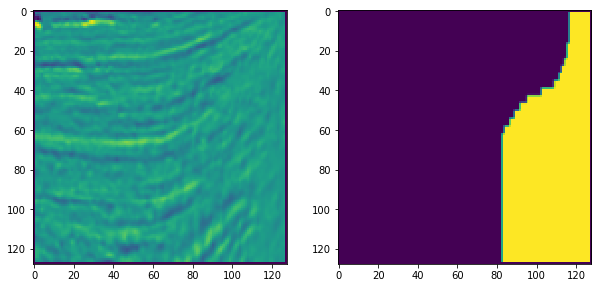

In [7]:
# show some data
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(X_train[0].squeeze())
plt.subplot(122)
plt.imshow(y_train[0].squeeze())
plt.show()

In [11]:
input_img = Input((128, 128, 1), name='img')
model = unet(input_img)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_21 

In [12]:
import time
start = time.time()
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1),
ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=4, epochs=30, callbacks=callbacks,validation_data=(X_valid, y_valid))
end = time.time()
print('execution time:',end-start)

Instructions for updating:
Use tf.cast instead.
Train on 68 samples, validate on 12 samples
Epoch 1/30
68/68 [==============================] - 44s 645ms/step - loss: 0.8450 - acc: 0.4502 - val_loss: 0.7700 - val_acc: 0.5045

Epoch 00001: val_loss improved from inf to 0.77004, saving model to model1.h5
Epoch 2/30
68/68 [==============================] - 40s 584ms/step - loss: 0.7986 - acc: 0.4354 - val_loss: 0.6881 - val_acc: 0.5745

Epoch 00002: val_loss improved from 0.77004 to 0.68806, saving model to model1.h5
Epoch 3/30
68/68 [==============================] - 39s 575ms/step - loss: 0.7500 - acc: 0.4627 - val_loss: 0.6463 - val_acc: 0.6064

Epoch 00003: val_loss improved from 0.68806 to 0.64630, saving model to model1.h5
Epoch 4/30
68/68 [==============================] - 39s 570ms/step - loss: 0.7208 - acc: 0.5073 - val_loss: 0.6268 - val_acc: 0.5824

Epoch 00004: val_loss improved from 0.64630 to 0.62685, saving model to model1.h5
Epoch 5/30
68/68 [==============================

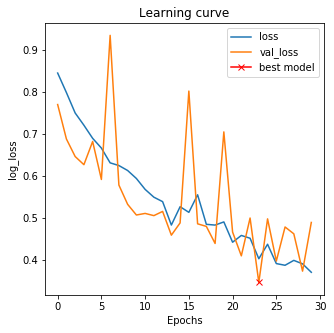

In [14]:
plt.figure(figsize=(5, 5))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Check the predictions

In [15]:
#import the best model and evaluate its performance on validation data
model.load_weights('model1.h5')
model.evaluate(X_valid, y_valid, verbose=1)

12/12 [==============================] - 2s 194ms/step


[0.3464941084384918, 0.9132944941520691]

In [16]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

12/12 [==============================] - 2s 192ms/step


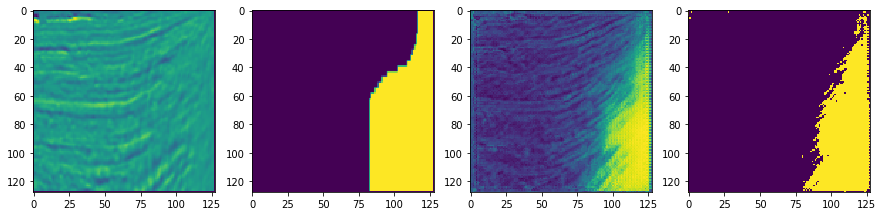

In [17]:
fig = plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(X_train[0].squeeze())
plt.subplot(142)
plt.imshow(y_train[0].squeeze())
plt.subplot(143)
plt.imshow(preds_train[0].squeeze())
plt.subplot(144)
plt.imshow(preds_train_t[0].squeeze())
plt.show()


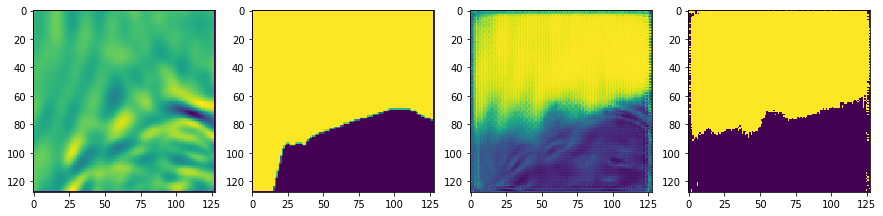

In [20]:
fig = plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(X_valid[0].squeeze())
plt.subplot(142)
plt.imshow(y_valid[0].squeeze())
plt.subplot(143)
plt.imshow(preds_val[0].squeeze())
plt.subplot(144)
plt.imshow(preds_val_t[0].squeeze())
plt.show()
